In [1]:
%load_ext autoreload
%autoreload 2

from rknot.dots import MATRIX_COL_LABELS as ML
from rknot.notebook import *
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML

plt.style.use('rknot_nb')
path = 'vids/seasonality'

---
## Seasonality ##

There are many viruses that exhibit seasonality. In particular, in North America, influenza and the common cold ([which is a catch-all for a collection of different viral strains](https://en.wikipedia.org/wiki/Common_cold)) predictably peak in the winter months and subside in the summer. The reasons for the seasonality of these viruses (and not others) is still somewhat of a mystery, but [the Harvard School Public Health provides a summary of potential factors here](https://ccdd.hsph.harvard.edu/will-covid-19-go-away-on-its-own-in-warmer-weather).

**Natural Progression of Immunity**

+ remarkably, the most relevant factor may have nothing at all to do with seasonality. A virus and its host population may have an immunity profile that results in an intrinsic ebb and flow of infections (that may or may not line up with typical regional seasons). For instance, [influenza immunity is believed to last for 3 months](https://www.cdc.gov/flu/professionals/acip/immunogenicity.htm#Duration), meaning that the potential host population subsides and then increases in time for the virus to re-emerge months later (to say nothing of the different types of influenza that might be prevalent during any season).

**Geological / Meteorological Factors**

+ Lower humidity has been shown to slow influenza spread although very high humditiy has been shown to increase it in tropical regions.
+ [Sun exposure and temperature have also been shown to impact influenza prevalence](https://ehp.niehs.nih.gov/doi/pdf/10.1289/ehp.1002383).

**Behavior Changes**

+ in colder environments, people tend to congregate indoors more frequently, in closer quarters and with worse ventalition. In particular, school seasonality in North America aligns with winter.
+ one should also consider that the *warmest* environments might experience inverse behavior to the coldest. People in the southern US, for example, may move indoors during the peak of summer to take advantage of air conditioning ([this was suggested by Nate Silver of FiveThirtyEight](https://twitter.com/NateSilver538/status/1273329472524222466)).

**Weakening Immune System**

+ there is limited research but it is also known that melatonin and vitamin D play a role in immune response. So individuals with less exposure to sunshine (whether due to covering up when outdoors or simply being indoors) may result in a greater number of infections.

[Professor Lipsitch of Harvard](https://ccdd.hsph.harvard.edu/will-covid-19-go-away-on-its-own-in-warmer-weather) is also very careful to emphasize that seasonal factors are likely much more relevant in *existing* viruses versus *new* viruses. The sheer size of the susceptible population of a new virus is likely enough to overwhelm the marginal impact of any one or all seasonal factors combined.

That said, even with new viruses, one would expect these factors to provide at least *some* resistance or reinforcement as they case may be.

---
### Location Transmission Factors ###

+ **RKnot** attempts to encapsulate the various factors above through a transmission factor associated with each location in the Grid. To account for seasonal changes, a separate transmission factor for each tick in the simulation can be assigned.
+ The result is a matrix of shape (# of locations, # of ticks). For now, transmission factors are assigned through the `boxf` attribute of a group or vbox and are input as an integer of 100x factor, consistent with other transmission factors used in the package.

+ Below, we show the `loc_tmf` for a simulation with features:
    + 1 group
    + 100 subjects
    + the group's box is identical to the Grid
    + all locations inside the box are assigned a transmission factor of `boxf=200`

In [2]:
from rknot import Sim, Chart
from rknot.parallel.env import Environment as Env
from rknot.space import create_matrix


group = {'n': 100, 'n_inf': 2, 'box': [1,10,1,10], 'box_is_gated': False, 'boxf': 200}
params = {'R0': 1.8,'imndur': 365, 'infdur': 14, 'density': 1, 'days': 150}

env = Env(params['density'], [group], [], params['imndur'], params['R0'], params['infdur'], np.array([]))
env.setup()

locmat, loc_tmf = create_matrix(params['days'], env.boxes, env.gates)

In [3]:
text = 'This results in the matrix below, with shape'
text += f' {loc_tmf.shape}. You can see that each location (rows) has the same'
text += ' transmission factor on each tick (columns).'
md(text)

This results in the matrix below, with shape (100, 150). You can see that each location (rows) has the same transmission factor on each tick (columns).

In [4]:
loc_tmf

array([[200, 200, 200, ..., 200, 200, 200],
       [200, 200, 200, ..., 200, 200, 200],
       [200, 200, 200, ..., 200, 200, 200],
       ...,
       [200, 200, 200, ..., 200, 200, 200],
       [200, 200, 200, ..., 200, 200, 200],
       [200, 200, 200, ..., 200, 200, 200]], dtype=int32)

Location transmission factors can take on any shape the user desires. In the example below, a series of cosine waves are used to create a single curve as follows:

+ season lasting 365 days
+ seasonal variability factor of 2x (lower variability factor leads to greater variability)
+ peak transmission factor occurs in the beginning
+ trough transmission factor occurs at the midpoint

This is meant as a rough approximation of seasonal factors impacting spread when it *begins* in the ***middle of winter***.

In [5]:
seasonal_range = 365
seasonal_factor = 2

x = np.linspace(0, 1, seasonal_range)
base = np.cos(2*np.pi*x)
s1 = -(1/6)*np.cos(-2*np.pi*3*x)
s2 = (1/48)*np.cos(-2*np.pi*5*x)

mixed = base + s1 + s2
tmf = 1 + mixed / seasonal_factor
tmf = (100*tmf).astype(np.int32)

The code above results in the following:

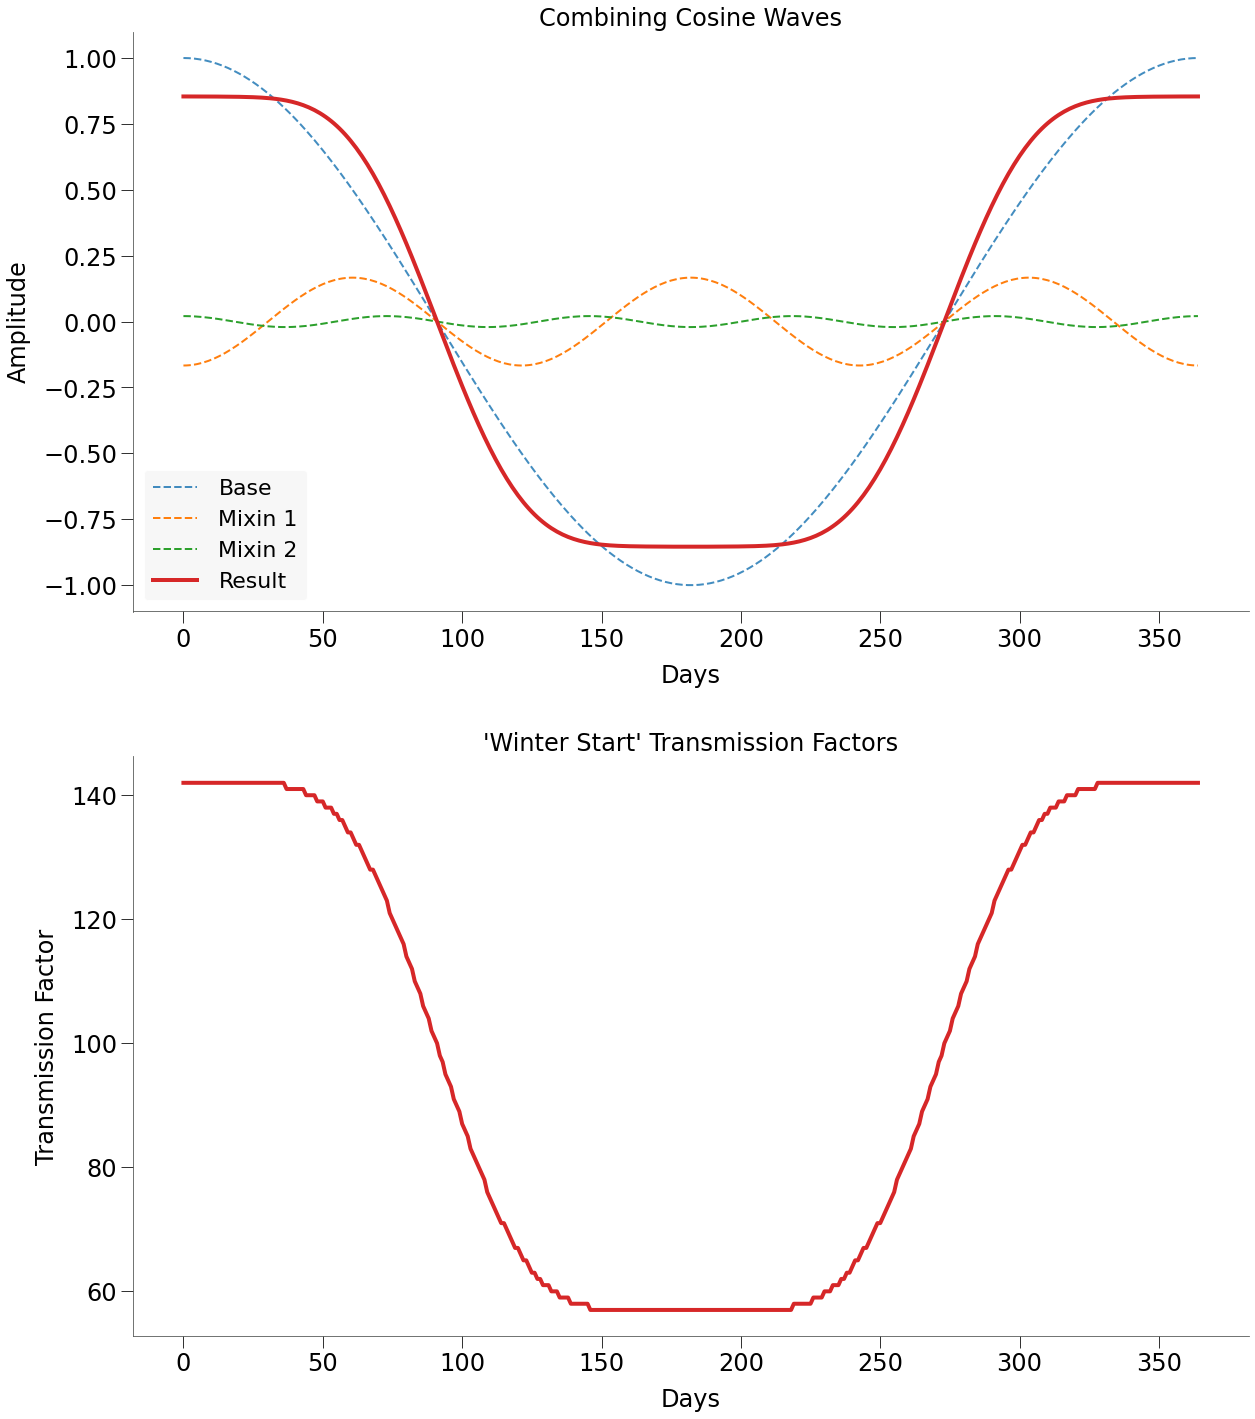

In [6]:
from matplotlib.ticker import FixedLocator

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,24))

ax1.plot(x, base, label='Base', lw=2, ls='--')
ax1.plot(x, s1, label='Mixin 1', lw=2, ls='--')
ax1.plot(x, s2, label='Mixin 2', lw=2, ls='--')
ax1.plot(x, mixed, label='Result', lw=4)

ax1.set_xticks(x)
ax1.set_xticklabels(np.arange(seasonal_range))
ax1.xaxis.set_major_locator(FixedLocator(x[::50]))

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax1.set_xlabel('Days')
ax1.set_ylabel('Amplitude')
ax1.set_title('Combining Cosine Waves')
ax1.legend(handlelength=2, handletextpad=1)

cycler = plt.rcParams['axes.prop_cycle']
colors = [c['color'] for c in cycler]
ax2.plot(x, tmf, c=colors[3], lw=4)

ax2.set_xticks(x)
ax2.set_xticklabels(np.arange(seasonal_range))
ax2.xaxis.set_major_locator(FixedLocator(x[::50]))

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax2.set_xlabel('Days')
ax2.set_ylabel('Transmission Factor')
ax2.set_title("'Winter Start' Transmission Factors")

fig.subplots_adjust(hspace=.25)

plt.show()

And shown in the `tmf` array below:

In [7]:
tmf

array([142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142,
       142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142,
       142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 141, 141,
       141, 141, 141, 141, 141, 140, 140, 140, 140, 139, 139, 139, 138,
       138, 138, 137, 137, 136, 136, 135, 134, 134, 133, 132, 132, 131,
       130, 129, 128, 128, 127, 126, 125, 124, 123, 121, 120, 119, 118,
       117, 116, 114, 113, 112, 110, 109, 108, 106, 105, 104, 102, 101,
       100,  98,  97,  95,  94,  93,  91,  90,  89,  87,  86,  85,  83,
        82,  81,  80,  79,  78,  76,  75,  74,  73,  72,  71,  71,  70,
        69,  68,  67,  67,  66,  65,  65,  64,  63,  63,  62,  62,  61,
        61,  61,  60,  60,  60,  59,  59,  59,  59,  58,  58,  58,  58,
        58,  58,  58,  57,  57,  57,  57,  57,  57,  57,  57,  57,  57,
        57,  57,  57,  57,  57,  57,  57,  57,  57,  57,  57,  57,  57,
        57,  57,  57,  57,  57,  57,  57,  57,  57,  57,  57,  5

Now we assign that `tmf` array to the `boxf` attribute of our group.

In [8]:
group = {'n': 100, 'n_inf': 2, 'box': [1,10,1,10], 'box_is_gated': False, 'boxf': tmf}
params = {'R0': 1.8,'imndur': 365, 'infdur': 14, 'density': 1, 'days': 365}

env = Env(params['density'], [group], [], params['imndur'], params['R0'], params['infdur'], np.array([]))
env.setup()

locmat, loc_tmf = create_matrix(params['days'], env.boxes, env.gates)

And in the resulting `loc_tmf` matrix, we can see that each location in the Grid has the same dynamic transmission factor across ticks.

In [9]:
loc_tmf[:3, :100]

array([[142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142,
        142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142,
        142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 141, 141,
        141, 141, 141, 141, 141, 140, 140, 140, 140, 139, 139, 139, 138,
        138, 138, 137, 137, 136, 136, 135, 134, 134, 133, 132, 132, 131,
        130, 129, 128, 128, 127, 126, 125, 124, 123, 121, 120, 119, 118,
        117, 116, 114, 113, 112, 110, 109, 108, 106, 105, 104, 102, 101,
        100,  98,  97,  95,  94,  93,  91,  90,  89],
       [142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142,
        142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142,
        142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 141, 141,
        141, 141, 141, 141, 141, 140, 140, 140, 140, 139, 139, 139, 138,
        138, 138, 137, 137, 136, 136, 135, 134, 134, 133, 132, 132, 131,
        130, 129, 128, 128, 127, 126, 125, 124, 123, 121, 120, 119, 11

If we invert the cosine waves, we can invert the seasonality curve, thereby mimicking an outbreak beginning in a region's summer period.

In [10]:
base = -np.cos(2*np.pi*x)
s1 = (1/6)*np.cos(-2*np.pi*3*x)
s2 = -(1/48)*np.cos(-2*np.pi*5*x)

mixed = base + s1 + s2
inv_tmf = 1 + mixed / seasonal_factor
inv_tmf = (100*inv_tmf).astype(np.int32)

This results in the curve below:

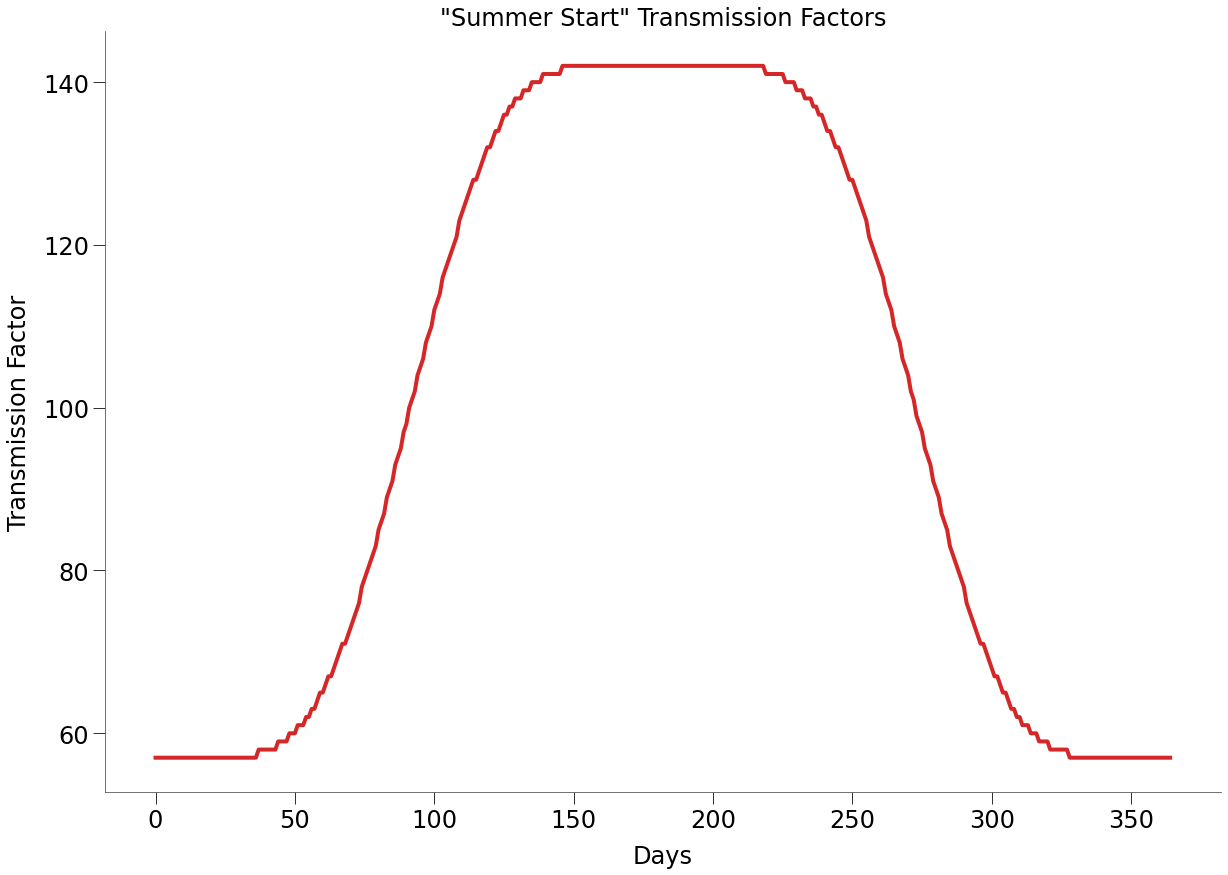

In [11]:
from matplotlib.ticker import FixedLocator

fig, ax = plt.subplots(figsize=(20,14))

ax.plot(x, inv_tmf, c=colors[3], lw=4)

ax.set_xticks(x)
ax.set_xticklabels(np.arange(seasonal_range))
ax.xaxis.set_major_locator(FixedLocator(x[::50]))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel('Days')
ax.set_ylabel('Transmission Factor')
ax.set_title('"Summer Start" Transmission Factors')

plt.show()

### SIR ###

We'll now utilize the pair of seasonality curves in some of the standard simulations demonstrated previously. First, we compare outcomes against the basic [Equal Mover scenario from the SIR section](hit.ipynb#1.-Equal).

The seasonal location factors are applied to every location across all groups. To do so, a box is created covering the entire grid and applied to each group by passing the keywords to each group.

We will compare the outcomes of an outbreak beginning in the Winter versus an outbreak beginning in Summer.

First, we create the `params` for the "Winter Start" seasonality.

In [12]:
from rknot.space import create_seasonal_factors

w_tmf = create_seasonal_factors()

gkws = {'box': [1,100,1,100], 'box_is_gated': False, 'boxf': w_tmf}
group1 = dict(name='0-19', n=2700, n_inf=0, ifr=0.00003, **gkws)
group2 = dict(name='20-49', n=4100, n_inf=1, ifr=0.0002, **gkws)
group3 = dict(name='50-69', n=2300, n_inf=1, ifr=0.005, **gkws)
group4 = dict(name='70+', n=900, n_inf=0, ifr=0.054, **gkws)
w_groups = [group1, group2, group3, group4]

w_params = {'groups': w_groups, 'density': 'med', 'R0':2.5, 'days': 365, 'imndur': 365, 'infdur': 14}

Then, we create the `params` for the "Summar Start" seasonality.

In [13]:
from copy import deepcopy

s_groups = deepcopy(w_groups)
s_params = deepcopy(w_params)

s_tmf = create_seasonal_factors(invert=True)
for group in s_groups:
    group['boxf'] = s_tmf

s_params['groups'] = s_groups

In [14]:
handles = ['winter', 'summer', 'aseasonal']
slugs = [f'sir_{h}' for h in handles]

if False:
    sims = pickloop(n=50, sterile=False, save={'path': path, 'slug': slugs[1]}, **w_params)
    sims = pickloop(n=50, sterile=False, save={'path': path, 'slug': slugs[2]}, **s_params)

    flat_groups = deepcopy(s_groups)
    flat_params = deepcopy(s_params)
    for g in flat_groups:
        g.pop('boxf')
    flat_params['groups'] = flat_groups
    sims = pickloop(n=49, sterile=False, save={'path': path, 'slug': slug_flat}, **flat_params)

In [15]:
files = [os.path.join(path, 'sims', s + '-pickled') for s in slugs]
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    args, sizes, res = table_inputs(*files)

sir_args, sir_sizes = args, sizes # assignment initiates garbage collection of pickled data

100%|██████████| 3/3 [00:34<00:00, 11.51s/it]


We generated 50 simulations encompassing the two seasonal scenarios and the original aseasonal scenario.

In [16]:
headers = [f'{h.capitalize()}' + r'<br>SIR<br>$R_0$ > 0' for h in handles]
display(HTML(curve_table(headers, sir_args, sir_sizes)))

,WinterSIR$R_0$ > 0,SummerSIR$R_0$ > 0,AseasonalSIR$R_0$ > 0
"n, $R_0$ > 0",50,38,50
n,50,50,50
Peak,54.2%,39.3%,37.7%
HIT,74.6%,68.3%,62.5%
Total,93.9%,90.9%,86.6%
Fatalities,0.58%,0.56%,0.52%
%>70,79.5%,79.2%,79.7%
IFR,0.62%,0.61%,0.60%
Days to Peak,51,110,66


The outbreak beginning during the winter reached its peak sooner and had a higher peak/hit/total infections (despite the shorter time frame).

The summer scenario has a much later peak and its peak/hit/total infections are lower than its winter cousin, BUT notice that all those values are higher than the original aseasonal scenario. Essentially, the virus lies in wait until the preferrable winter season arrives.

Below we show the animation of a represented simulation of the Winter scenario.

```python
sim = Sim(**w_params)
sim.run(dotlog=True)
chart = Chart(sim).to_html5_video()
```

In [17]:
if False:
    sim, res = sim_finder(w_params, crit={'idx': -1, 'val': 45, 'how': 'gt'})

    chart_params = dict(reso_format='web', dotsize=5)
    chart = Chart(
        sim, yscale='tot', show_intro=False, show_restricted=False, **chart_params
    ).save(os.path.join(path, 'tests', f'{slugs[0]}_peaks.mp4'))

In [18]:
from IPython.core.display import display, HTML
from rknot.notebook import animHTML

display(HTML(animHTML(f'seasonal/{slugs[0]}_peaks')))

And now the Summer scenario.

```python
sim = Sim(**s_params)
sim.run(dotlog=True)
chart = Chart(sim).to_html5_video()
```

In [19]:
if False:
    sim, res = sim_finder(w_params, crit={'idx': -1, 'val': 105, 'how': 'gt'})
    chart_params = dict(reso_format='web', dotsize=5)

    chart = Chart(
        sim, yscale='tot', show_intro=False, show_restricted=False, **chart_params
    ).save(os.path.join(path, 'tests', f'{handles[1]}_peaks.mp4'))

In [20]:
from IPython.core.display import display, HTML
from rknot.notebook import animHTML

display(HTML(animHTML(f'seasonal/{slugs[1]}_peaks')))

Above we can see how resilient the virus is in the face of some seasonal resistance. The virus barely survives, relying on a handful of hosts for almost 100 days, and once the seasonality factors begin to contribute to spread and exponential pandemic occurs.

---
### Events ###

We can easily incorporate these location-based, seasonal transmission factors into more complex structures. We again compare "Winter Start" and "Summer Start" seasonal factors into our [dynamic load, event-based structure](load.ipynb#Events).

**NOTE**: Seasonal factors cannot be created for locations *not* inside a box. In the event structure, the region where the events occur is inside a VBox, however, the remaining region does *not* occur in a box and so the no transmission factor is applied. The number of contacts outside of the VBox is a very small portion of the total and so should not impact the result materially.

Here is the structure:

In [21]:
from rknot import Sim, Chart
from rknot.dots.fhutch import tmr
from rknot.space import create_seasonal_factors
from rknot.events import Restriction, Quarantine
from rknot.sims.us_w_load_18 import events

rsxns = []
quars = []
events_loc = []
for e in events:
    if isinstance(e, Restriction):
        rsxns.append(e)
    elif isinstance(e, Quarantine):
        quars.append(e)
    else:
        e.from_boxes = []
        e.no_events = True
        events_loc.append(e)

group1 = dict(name='0-19', n=2700, n_inf=0, ifr=0.00003, mover=.98)
group2 = dict(name='20-49', n=4100, n_inf=1, ifr=0.0002, mover=.98)
group3 = dict(name='50-69', n=2300, n_inf=1, ifr=0.005, mover=.98)
group4 = dict(name='70+', n=900, n_inf=0, ifr=0.054, mover=.98)
groups = [group1, group2, group3, group4]

w_tmf = create_seasonal_factors()
w_vbox = {'label': 344, 'box': 344, 'boxf': w_tmf}
w_params = {
    'groups': groups, 'density': 1, 
    'days': 365, 'tmr_curve': tmr, 
    'vboxes': w_vbox, 'events': events_loc,
    'rsxns': rsxns, 
}

s_tmf = create_seasonal_factors(invert=True)
s_vbox = {'label': 344, 'box': 344, 'boxf': s_tmf}
s_params = deepcopy(w_params)
s_params['vboxes'] = s_vbox

In [22]:
handles = ['winter', 'summer', 'aseasonal']
slugs = [f'eve_{h}' for h in handles]

if False:
    sims = pickloop(
        n=50, sterile=False, save={'path': path, 'slug': slugs[0]}, 
        **w_params
    )
    sims = pickloop(
        n=50, sterile=False, save={'path': path, 'slug': slugs[1]}, 
        **s_params
    )    

    flat_vbox = {'label': 344, 'box': 344}
    flat_params = {
        'groups': groups, 'density': 1, 
        'days': 365, 'tmr_curve': tmr, 
        'vboxes': flat_vbox, 'events': events_loc,
        'rsxns': rsxns, 
    }
    sims = pickloop(
        n=40, sterile=False, save={'path': path, 'slug': slugs[2]}, 
        **flat_params
    )

In [23]:
files = [os.path.join(path, 'sims', s + '-pickled') for s in slugs]
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    args, sizes, res = table_inputs(*files)

eve_args, eve_sizes, eve_res = args, sizes, res

100%|██████████| 3/3 [00:25<00:00,  8.41s/it]


We ran 50 simulations of 3 scenarios with the outcomes below.

In [24]:
headers = [f'{h.capitalize()}' + r'<br>Events<br>$R_0$ > 0' for h in handles]
display(HTML(curve_table(headers, eve_args, eve_sizes)))

,WinterEvents$R_0$ > 0,SummerEvents$R_0$ > 0,AseasonalEvents$R_0$ > 0
"n, $R_0$ > 0",20,0,8
n,50,50,50
Peak,52.1%,nan%,36.0%
HIT,57.9%,nan%,42.3%
Total,65.7%,nan%,53.6%
Fatalities,0.40%,nan%,0.34%
%>70,81.2%,0.0%,74.6%
IFR,0.61%,nan%,0.63%
Days to Peak,62,nan,71


As expected, the Winter Start scenario resulted in larger spread and faster peak. Less expected, the Summer Start scenario resulted in *exactly ZERO* outbreaks. The seasonal factors and the concentrated contacts thwarted spread in every simulation.

Below we show the animation for the Winter Start scenario.

```python
sim = Sim(**w_params)
sim.run()
chart = Chart(sim)
chart.to_html5_video()
```

In [25]:
if False:
    sim, res = sim_finder(w_params, crit={'idx': -1, 'val': 55, 'how': 'gt'})
    chart_params = dict(reso_format='web', dotsize=5)

    chart = Chart(
        sim, yscale='tot', show_intro=False, show_restricted=False, **chart_params
    ).save(os.path.join(path, 'tests', f'{slugs[0]}_peaks.mp4'))

In [26]:
from IPython.core.display import display, HTML
from rknot.notebook import animHTML

display(HTML(animHTML(f'seasonal/{slugs[0]}_peaks')))

In [27]:
if False:    
    sim = Sim(**s_params)
    sim.run(dotlog=True)
    
    chart_params = dict(reso_format='web', dotsize=5)

    chart = Chart(
        sim, yscale='tot', show_intro=False, show_restricted=False, **chart_params
    ).save(os.path.join(path, 'tests', f'{slugs[1]}_peaks.mp4'))

---
### Borders ###

We can see the impact of seasonal factors most clearly when they are employed in separate jurisidctions.

Here we will implement a single scenario based the [Borders scenario](multi.ipynb#Borders) with each state having differing seasonal factors. The West State will have Winter Start seasonal factor and the East State will have Summer Start seasonal factors. This is analogous, say, to northern US states versus souther US states during the COVID19 outbreak.

*Remember this scenario does* $\underline{not}$ *have mixing between the two regions.*

In [28]:
from copy import deepcopy

from rknot import Sim, Chart
from rknot.events import Restriction, Quarantine
from rknot.dots.fhutch import tmr
from rknot.sims import us_w_load_multi_8g
from rknot.space import create_seasonal_factors

w_tmf = create_seasonal_factors()
wbox = {'label': 'W Main', 'box': 344, 'boxf': w_tmf}

e_tmf = create_seasonal_factors(invert=True)
ebox = {'label': 'E Main', 'box': 344, 'boxf': e_tmf}


vboxes = [wbox, ebox]
params = us_w_load_multi_8g.params_borders
params['vboxes'] = vboxes

In [29]:
handles = ['seasonal', 'aseasonal']
slugs = [f'bord_{h}' for h in handles]

if False:
    sims = pickloop(
        n=50, sterile=False, save={'path': path, 'slug': slugs[0]}, 
        **params
    )

In [30]:
files = [
    os.path.join(path, 'sims', slugs[0] + '-pickled'),
    os.path.join('vids/multi', 'sims', 'mixed-pickled'),
]
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    args, sizes, res = table_inputs(*files)

bor_args, bor_sizes, bor_res = args, sizes, res # ensures garbage collection of pickled files

100%|██████████| 2/2 [00:43<00:00, 21.67s/it]


Below are 50 simulations of the seasonal scenario (with two regions wiht differing seasonal factors) and the aseasonal scenario.

In [31]:
headers = [f'{h.capitalize()}' + r'<br>Borders<br>$R_0$ > 0' for h in handles]
display(HTML(curve_table(headers, args, sizes)))

,SeasonalBorders$R_0$ > 0,AseasonalBorders$R_0$ > 0
"n, $R_0$ > 0",20,28
n,50,50
Peak,26.6%,23.5%
HIT,29.6%,38.0%
Total,33.3%,53.3%
Fatalities,0.20%,0.32%
%>70,79.7%,79.1%
IFR,0.60%,0.60%
Days to Peak,62,95


The seasonal scenario typically results in a smaller outbreak, with the peak occuring much earlier. More interesting than the average data, however, is the split among the two regions in the seasonal scenario.

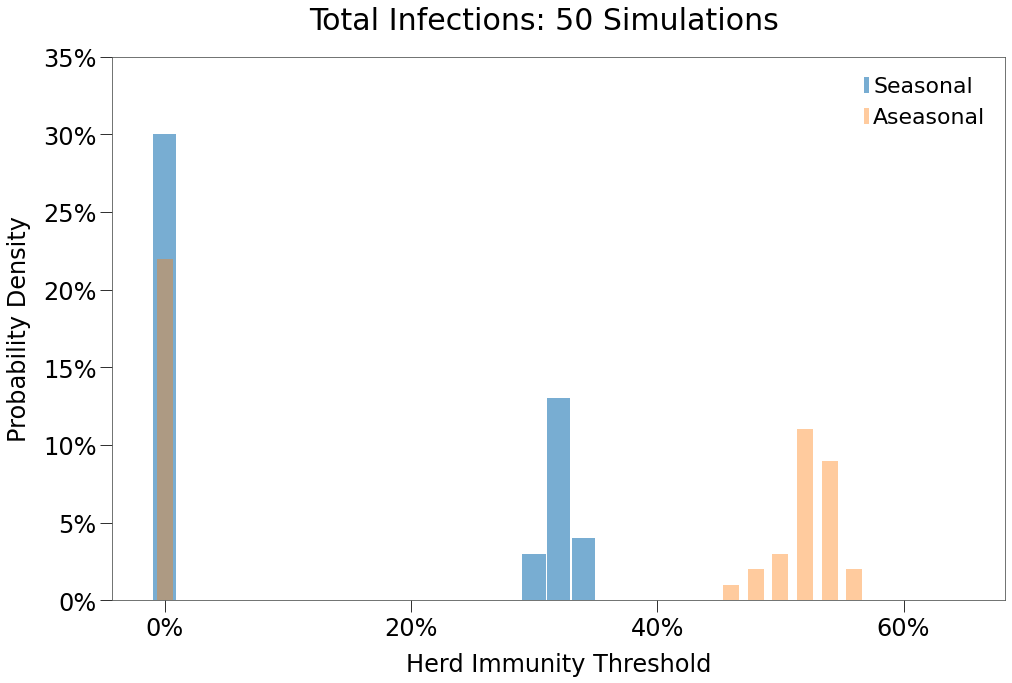

In [58]:
from rknot.notebook import curvehist
savepath = 'vids/seasonality/border_hist'

title = f'Total Infections: {bor_res[0].shape[0]} Simulations'
labels = ['Seasonal', 'Aseasonal']

curvehist(np.array(bor_res)[:,:,2], title=title, which='hit', widths=[.95, .65], labels=labels, savepath=savepath)

Above we see that not a single seasonal simulation ended with HIT > 40%. This suggests that only one region experienced outbreaks in these simulations. Below we can see this is in fact the case.

/Users/spindicate/Documents/programming/rknot/rknot/notebook/data.py:123: RuntimeWarning: invalid value encountered in double_scalars
  _70 = _70/group_deps.sum()


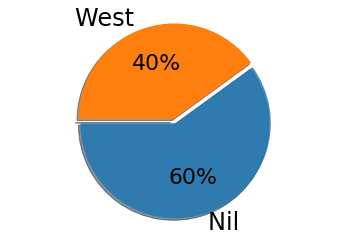

In [38]:
peakset, _ = save_peakpie(files[0], path, slugs[0])

In [39]:
from IPython.core.display import display, HTML
display(HTML(peakcomp(peakset, 'seasonal', slugs[0])))

In all 20 instances of an outbreak, the outbreak occured in the West State, where the outbreak began during the Winter. The East state had *zero* outbreaks across the 50 simulations.

We can see a sample simulation below:

In [59]:
if False:
    sim, res = sim_finder(params, {'idx': 2, 'val': [.2, .4], 'how': 'bw'})
    chart_params = dict(reso_format='web', dotsize=5)

    groupings = {'West': [0,1,2,3], 'East': [4,5,6,7]}
    yscale = 'peaks'
    chart = Chart(
        sim, yscale=yscale, groupings=groupings, show_intro=False, show_restricted=False, **chart_params
    ).save(os.path.join(path, 'tests', f'{slugs[0]}_west_{yscale}.mp4'))
    yscale = 'tot'
    chart = Chart(
        sim, yscale=yscale, groupings=groupings, show_intro=False, show_restricted=False, **chart_params
    ).save(os.path.join(path, 'tests', f'{slugs[0]}_west_{yscale}.mp4'))    

In [41]:
from IPython.core.display import display, HTML
from rknot.notebook import animHTML

display(HTML(animHTML(f'seasonal/{slugs[0]}_west_tot')))

### Borders w Crossing ###

Finally, we can see how mixing between our two regions above may further impact spread. This scenario will build on the [Border Crossing scenario](multi.ipynb#Crossings-with-Event-Access), allowing travel between West and East States and a regular basis.

In [42]:
from rknot.events import Travel

import numpy as np
from copy import deepcopy

from rknot import Sim, Chart
from rknot.events import Restriction, Quarantine
from rknot.dots.fhutch import tmr
from rknot.sims import us_w_load_multi_8g
from rknot.notebook import *
from rknot.space import create_seasonal_factors

modulereload(us_w_load_multi_8g)
params = us_w_load_multi_8g.params_borders

# Randomize location of events
n_cross = 9
xs = np.random.randint(19, 120, size=n_cross)
ys = np.random.randint(20, 120, size=n_cross)
w_locs = np.vstack((xs, ys)).T

xs = np.random.randint(74, 120, size=n_cross)
ys = np.random.randint(10, 120, size=n_cross)
e_locs = np.vstack((xs, ys)).T

crosses = []
for i in range(n_cross):
    crosses += [Travel(name=f'WtoE_{i}', xy=e_locs[i], start_tick=1,
        groups=[0,1,2,3], capacity=1, recurring=1
    )]
    crosses += [Travel(
        name=f'EtoW_{i}', xy=w_locs[i], start_tick=1,
        groups=[4,5,6,7], capacity=1, recurring=1
    )]
params['events'] += crosses

w_tmf = create_seasonal_factors()
wbox = {'label': 'W Main', 'box': 344, 'boxf': w_tmf}
e_tmf = create_seasonal_factors(invert=True)
ebox = {'label': 'E Main', 'box': 344, 'boxf': e_tmf}
vboxes = [wbox, ebox]
params['vboxes'] = vboxes

In [43]:
handles = ['seasonal', 'aseasonal']
slugs = [f'cross_{h}' for h in handles]
if False:
    pickloop(
        n=50, sterile=False, save={'path': path, 'slug': slugs[0]}, 
        **params
    )

In [44]:
files = [
    os.path.join(path, 'sims', slugs[0] + '-pickled'),
    os.path.join('vids/multi', 'sims', 'border_crossing_multi-pickled'),
]

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    args, sizes, res = table_inputs(*files)

bx_args, bx_sizes, bx_res = args, sizes, res

100%|██████████| 2/2 [01:14<00:00, 37.19s/it]


The results of 50 simulations are shown below:

In [60]:
headers = [r'Crossing<br>Seasonal<br>$R_0$ > 0', r'Crossing<br>Aseasonal<br>$R_0$ > 0']
display(HTML(curve_table(headers, bx_args, bx_sizes)))

,CrossingSeasonal$R_0$ > 0,CrossingAseasonal$R_0$ > 0
"n, $R_0$ > 0",25,21
n,50,52
Peak,25.3%,23.4%
HIT,28.5%,35.6%
Total,38.4%,51.8%
Fatalities,0.24%,0.33%
%>70,78.1%,75.8%
IFR,0.63%,0.64%
Days to Peak,63,86


Again, the seasonsal scenario results in fewer infections in a shorter time frame.

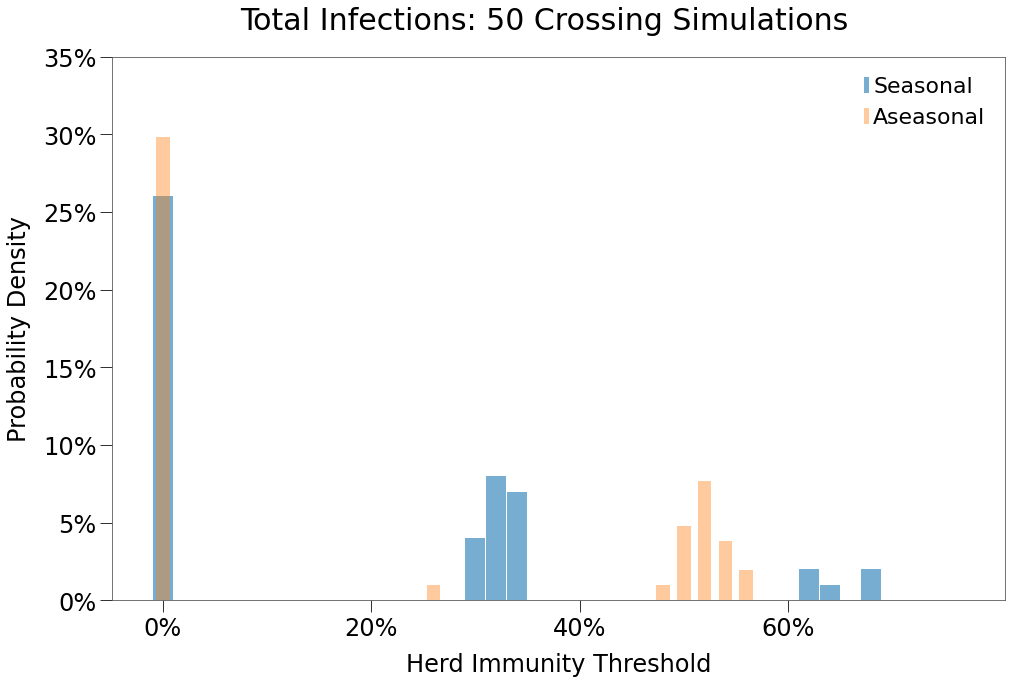

In [46]:
from rknot.notebook import curvehist
savepath = 'vids/seasonality/cross_hist'

title = f'Total Infections: {bx_res[0].shape[0]} Crossing Simulations'
labels = ['Seasonal', 'Aseasonal']

curvehist([bx_res[0][:, 2], bx_res[1][:, 2]], title=title, which='hit', widths=[.95, .65], labels=labels, savepath=savepath)

In contrast with the prior scenario (which did not allow any travel), there are now several simulations with HIT > 60%, suggesting outbreaks occurred in both states in some instances.

Below we show region comparison for both the seasonal and aseasonal outcomes.

/Users/spindicate/Documents/programming/rknot/rknot/notebook/data.py:123: RuntimeWarning: invalid value encountered in double_scalars
  _70 = _70/group_deps.sum()


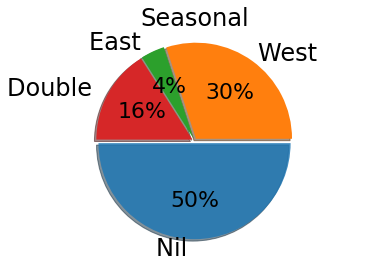

In [47]:
peakset, sstack = save_peakpie(files[0], path, slugs[0], 'Seasonal')

In [48]:
from IPython.core.display import display, HTML
display(HTML(peakcomp(peakset, 'seasonal', slugs[0])))

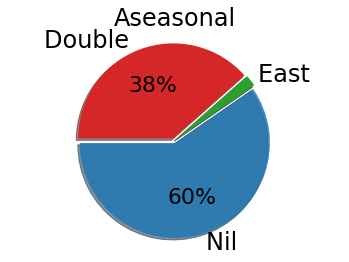

In [49]:
peakset, _ = save_peakpie(files[1], path, slugs[1], 'Aseasonal')

In [50]:
from IPython.core.display import display, HTML
display(HTML(peakcomp(peakset, 'seasonal', slugs[1])))

Above, we can see that, despite the significant mixing, the East State is still fairly protected from an outbreak due to its lower seasonal factors at the early stages of the outbreak. And this results in much better outcomes for the East State.

We can see this even more clearly in the chart below. Note that in only 1 instance did the East State have an outbreak while the West State did not.

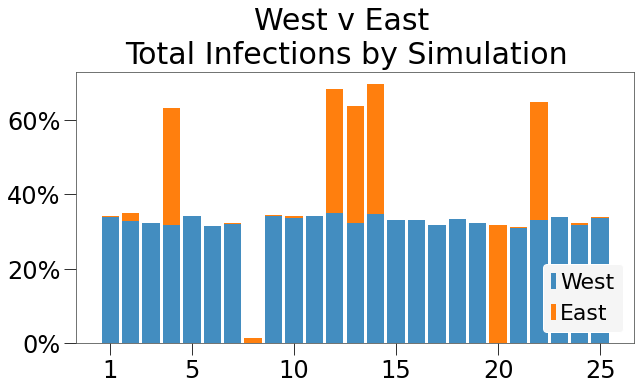

In [51]:
regionhist(sstack, path)

Below we see sample simulations for both a single, West State peak and peaks in both regions.

```python
sim = Sim(**w_params)
sim.run()
chart = Chart(sim)
chart.to_html5_video()
```

In [63]:
if False:
    sim, res = sim_finder(params, crit={'idx': 2, 'val': .6, 'how': 'lt'})
    chart_params = dict(reso_format='web', dotsize=5)

    chart = Chart(
        sim, yscale='tot', show_intro=False, show_restricted=True, **chart_params
    ).save(os.path.join(path, 'tests', f'{slugs[0]}_double_peaks.mp4'))

In [64]:
if False:
    sim, res = sim_finder(crit={'idx': 2, 'val': [.2, .4], 'how': 'bw'}, mem=15, ray_loglevel='fatal', **params)
    chart_params = dict(reso_format='web', dotsize=2.5)

    chart = Chart(
        sim, yscale='tot', show_intro=False, show_restricted=True, **chart_params
    ).save(os.path.join(path, 'tests', f'{slugs[0]}_single_peaks.mp4'))    

In [65]:
from IPython.core.display import display, HTML
from rknot.notebook import animHTML

display(HTML(animHTML(f'seasonal/{slugs[0]}_double_peaks')))

In [66]:
from IPython.core.display import display, HTML
from rknot.notebook import animHTML

display(HTML(animHTML(f'seasonal/{slugs[0]}_single_peaks')))

In [ ]:
%%javascript
IPython.notebook.save_notebook()

In [62]:
from rknot.notebook import move_to_doc_folder
move_to_doc_folder('seasonal.ipynb')